In [2]:
import os

# Data Manipulation
import pandas as pd
import numpy as np
from pandas.io.stata import StataReader

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from scipy import stats
import statsmodels.formula.api as sm


# Profiling
import ydata_profiling as yp

# para a análise de dados espaciais
import geopandas as gp
import pysal as ps
import splot
import mapclassify as mc
# from libpysal.weights import Queen
# from libpysal import weights
# from esda import Moran, Moran_Local, G_Local
# from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# 1. Reading the data

In [3]:
# Read the file and the labels
with StataReader('../../dados/microdados-processados/amostra_domicilios_2010_RJ.dta') as reader:
    data_micro = reader.read(convert_categoricals=False)
    col_labels = reader.variable_labels()
    value_labels = reader.value_labels()

# Remove '_lbl' from the keys in value_labels
value_labels = {k.replace('_lbl', ''): v for k, v in value_labels.items()}

# Apply the labels to the data
for col, labels in value_labels.items():
    if col in data_micro:
        data_micro[col] = data_micro[col].map(labels)

# Apply the labels to the columns
data_micro = data_micro.rename(columns=col_labels)

# Convert ÁREA DE PONDERAÇÃO to int64
data_micro['ÁREA DE PONDERAÇÃO'] = data_micro['ÁREA DE PONDERAÇÃO'].astype('int64')
# Transform the column to string, remove the 8th character and convert back to int64
# This is done to make the column joinable with CD_GEOCODB from the SHP data
data_micro['ÁREA DE PONDERAÇÃO'] = data_micro['ÁREA DE PONDERAÇÃO'].astype(str).apply(lambda x: x[:7] + x[8:]).astype('int64')


filtra apenas os dados do RJ

In [4]:
df_rio = data_micro[data_micro['CÓDIGO DO MUNICÍPIO'] == 'Rio de Janeiro']
df_rio.info()
df_rio.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104712 entries, 196547 to 301258
Data columns (total 76 columns):
 #   Column                                                                            Non-Null Count   Dtype  
---  ------                                                                            --------------   -----  
 0   UNIDADE DA FEDERAÇÃO                                                              104712 non-null  object 
 1   CÓDIGO DO MUNICÍPIO                                                               104712 non-null  object 
 2   ÁREA DE PONDERAÇÃO                                                                104712 non-null  int64  
 3   CONTROLE                                                                          104712 non-null  float64
 4   PESO AMOSTRAL                                                                     104712 non-null  float64
 5   REGIÃO GEOGRÁFICA                                                                 104712 non-nu

,UNIDADE DA FEDERAÇÃO,CÓDIGO DO MUNICÍPIO,ÁREA DE PONDERAÇÃO,CONTROLE,PESO AMOSTRAL,REGIÃO GEOGRÁFICA,CÓDIGO DA MESORREGIÃO,CÓDIGO DA MICRORREGIÃO,CÓDIGO DA REGIÃO METROPOLITANA,SITUAÇÃO DO DOMICÍLIO,...,MARCA DE IMPUTAÇÃO NA V0218,MARCA DE IMPUTAÇÃO NA V0219,MARCA DE IMPUTAÇÃO NA V0220,MARCA DE IMPUTAÇÃO NA V0221,MARCA DE IMPUTAÇÃO NA V0222,MARCA DE IMPUTAÇÃO NA V0301,MARCA DE IMPUTAÇÃO NA V0401,MARCA DE IMPUTAÇÃO NA V0402,MARCA DE IMPUTAÇÃO NA V0701,Situação do setor
196547,Rio de Janeiro,Rio de Janeiro,330455705001,2171.0,1.824236e+14,Região sudeste (uf=31 a 33 e 35),Metropolitana do Rio de Janeiro,Rio de Janeiro,19,Urbana,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Área urbanizada
196548,Rio de Janeiro,Rio de Janeiro,330455705001,11523.0,2.207511e+14,Região sudeste (uf=31 a 33 e 35),Metropolitana do Rio de Janeiro,Rio de Janeiro,19,Urbana,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Área urbanizada
196549,Rio de Janeiro,Rio de Janeiro,330455705001,13794.0,1.441748e+14,Região sudeste (uf=31 a 33 e 35),Metropolitana do Rio de Janeiro,Rio de Janeiro,19,Urbana,...,Não,Não,Não,Não,Não,Não,Não,Não,Não,Área urbanizada
196550,Rio de Janeiro,Rio de Janeiro,330455705001,22268.0,1.832662e+14,Região sudeste (uf=31 a 33 e 35),Metropolitana do Rio de Janeiro,Rio de Janeiro,19,Urbana,...,Não,Não,Não,Não,Não,Não,Não,Sim,Não,Área urbanizada
196551,Rio de Janeiro,Rio de Janeiro,330455705001,37328.0,1.783257e+14,Região sudeste (uf=31 a 33 e 35),Metropolitana do Rio de Janeiro,Rio de Janeiro,19,Urbana,...,Não,Não,Não,Não,Não,Não,Não,Sim,Não,Área urbanizada


# 2. Importando SHP

In [5]:
# Read the shapefile
gdf = gp.read_file('shp/rj_setores_censitarios/33SEE250GC_SIR.shp')

# Filter the data to only the city of Rio de Janeiro
gdf_rio = gdf[gdf['NM_MUNICIP'] == 'RIO DE JANEIRO']
gdf_rio.head()

# Select the column with the code of the area and the geometry
selected_columns = ['CD_GEOCODB', 'NM_BAIRRO', 'geometry']
gdf_rio = gdf_rio[selected_columns]
gdf_rio['CD_GEOCODB'] = gdf_rio['CD_GEOCODB'].astype('int64')

gdf_rio.info()
gdf_rio.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 10504 entries, 10708 to 23328
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   CD_GEOCODB  10504 non-null  int64   
 1   NM_BAIRRO   10504 non-null  object  
 2   geometry    10504 non-null  geometry
dtypes: geometry(1), int64(1), object(1)
memory usage: 328.2+ KB


,CD_GEOCODB,NM_BAIRRO,geometry
10708,330455705005,Catumbi,"POLYGON ((-43.19949 -22.92454, -43.19953 -22.9..."
10709,330455705005,Catumbi,"POLYGON ((-43.19795 -22.91829, -43.19819 -22.9..."
10710,330455705005,Catumbi,"POLYGON ((-43.19858 -22.91876, -43.19888 -22.9..."
10711,330455705005,Catumbi,"POLYGON ((-43.19879 -22.91937, -43.19879 -22.9..."
10712,330455705005,Catumbi,"POLYGON ((-43.19791 -22.92028, -43.19791 -22.9..."


## 3. Transformação dos dados

## 3.1. Tratando de dados que foram carregados errados

In [6]:
v6529 = 'RENDIMENTO MENSAL DOMICILIAR EM JULHO DE 2010 '
df_rio[v6529] = df_rio[v6529]
v6530 = 'RENDIMENTO DOMICILIAR, SALÁRIOS MÍNIMOS, EM JULHO DE 2010 '
df_rio[v6530] = df_rio[v6530]/10**5
v6531 = 'RENDIMENTO DOMICILIAR PER CAPITA EM JULHO DE 2010 '
df_rio[v6531] = df_rio[v6531]/10**2
v6532 = 'RENDIMENTO DOMICILIAR PER CAPITA, EM Nº DE SALÁRIOS MÍNIMOS, EM JULHO DE 2010 '
df_rio[v6532] = df_rio[v6532]/10**5

C:\Users\gianl\AppData\Local\Temp\ipykernel_20216\523567008.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rio[v6529] = df_rio[v6529]
C:\Users\gianl\AppData\Local\Temp\ipykernel_20216\523567008.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rio[v6530] = df_rio[v6530]/10**5
C:\Users\gianl\AppData\Local\Temp\ipykernel_20216\523567008.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

## 3.2. Agregando os dados por bairro

In [7]:
# Choose a column to be the numeric column
data_columns = [v6529, v6530, v6531, v6532]
aux_columns = ['ÁREA DE PONDERAÇÃO', 'PESO AMOSTRAL'] + data_columns

# Select only the columns that will be used
df_rio_filtered = df_rio[aux_columns]

# Define a function to calculate the weighted average
def weighted_avg(group, avg_name, weight_name):
    """ Calculate weighted avg """
    return np.average(group[avg_name], weights=group[weight_name])

# Group the DataFrame and calculate the weighted average
df_rio_filtered = df_rio_filtered.fillna(df_rio_filtered.mean())

for col in data_columns:
    df_rio_filtered[col + '_ponderado'] = df_rio_filtered[col] * df_rio_filtered['PESO AMOSTRAL']

# Calculate the weighted average
# df_rio_grouped = df_rio_filtered.groupby('ÁREA DE PONDERAÇÃO').apply(lambda x: pd.Series({col: weighted_avg(x, col, 'PESO AMOSTRAL') for col in data_columns}))
df_rio_grouped = df_rio_filtered.groupby('ÁREA DE PONDERAÇÃO').mean()

In [8]:
df_rio_grouped.head()

,PESO AMOSTRAL,RENDIMENTO MENSAL DOMICILIAR EM JULHO DE 2010,"RENDIMENTO DOMICILIAR, SALÁRIOS MÍNIMOS, EM JULHO DE 2010",RENDIMENTO DOMICILIAR PER CAPITA EM JULHO DE 2010,"RENDIMENTO DOMICILIAR PER CAPITA, EM Nº DE SALÁRIOS MÍNIMOS, EM JULHO DE 2010",RENDIMENTO MENSAL DOMICILIAR EM JULHO DE 2010 _ponderado,"RENDIMENTO DOMICILIAR, SALÁRIOS MÍNIMOS, EM JULHO DE 2010 _ponderado",RENDIMENTO DOMICILIAR PER CAPITA EM JULHO DE 2010 _ponderado,"RENDIMENTO DOMICILIAR PER CAPITA, EM Nº DE SALÁRIOS MÍNIMOS, EM JULHO DE 2010 _ponderado"
ÁREA DE PONDERAÇÃO,,,,,,,,,
330455705001,1.988433e+14,1616.691404,3.169983,615.694244,1.207244,3.171065e+17,6.217774e+14,1.216487e+17,2.385269e+14
330455705002,2.063235e+14,9401.894971,18.435088,4343.916329,8.517483,1.901789e+18,3.728998e+15,8.692383e+17,1.704389e+15
330455705003,2.066427e+14,9870.906475,19.354719,4786.630767,9.385551,2.068454e+18,4.055792e+15,1.022892e+18,2.005670e+15
330455705004,2.052917e+14,2092.003279,4.101967,759.265960,1.488757,4.238732e+17,8.311240e+14,1.574315e+17,3.086893e+14
330455705005,2.109711e+14,1688.101546,3.310003,611.078992,1.198194,3.584302e+17,7.028043e+14,1.309922e+17,2.568475e+14


## 3.2. Juntando os dados com o Shapefile

In [9]:
gdf_rio_filter = gdf_rio[['NM_BAIRRO', 'geometry', 'CD_GEOCODB']].set_index('CD_GEOCODB')

# Join the dataframes
gdf_rio_join = gdf_rio_filter.join(df_rio_grouped, how='inner')

gdf_rio_join.info()
gdf_rio_join.head()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 10504 entries, 330455705001 to 330455705160
Data columns (total 11 columns):
 #   Column                                                                                    Non-Null Count  Dtype   
---  ------                                                                                    --------------  -----   
 0   NM_BAIRRO                                                                                 10504 non-null  object  
 1   geometry                                                                                  10504 non-null  geometry
 2   PESO AMOSTRAL                                                                             10504 non-null  float64 
 3   RENDIMENTO MENSAL DOMICILIAR EM JULHO DE 2010                                             10504 non-null  float64 
 4   RENDIMENTO DOMICILIAR, SALÁRIOS MÍNIMOS, EM JULHO DE 2010                                 10504 non-null  float64 
 5   RENDIMENTO DOMICILIA

,NM_BAIRRO,geometry,PESO AMOSTRAL,RENDIMENTO MENSAL DOMICILIAR EM JULHO DE 2010,"RENDIMENTO DOMICILIAR, SALÁRIOS MÍNIMOS, EM JULHO DE 2010",RENDIMENTO DOMICILIAR PER CAPITA EM JULHO DE 2010,"RENDIMENTO DOMICILIAR PER CAPITA, EM Nº DE SALÁRIOS MÍNIMOS, EM JULHO DE 2010",RENDIMENTO MENSAL DOMICILIAR EM JULHO DE 2010 _ponderado,"RENDIMENTO DOMICILIAR, SALÁRIOS MÍNIMOS, EM JULHO DE 2010 _ponderado",RENDIMENTO DOMICILIAR PER CAPITA EM JULHO DE 2010 _ponderado,"RENDIMENTO DOMICILIAR PER CAPITA, EM Nº DE SALÁRIOS MÍNIMOS, EM JULHO DE 2010 _ponderado"
330455705001,Centro,"POLYGON ((-43.19734 -22.90729, -43.19833 -22.9...",1.988433e+14,1616.691404,3.169983,615.694244,1.207244,3.171065e+17,6.217774e+14,1.216487e+17,2.385269e+14
330455705001,Centro,"POLYGON ((-43.19133 -22.90252, -43.19178 -22.9...",1.988433e+14,1616.691404,3.169983,615.694244,1.207244,3.171065e+17,6.217774e+14,1.216487e+17,2.385269e+14
330455705001,Centro,"POLYGON ((-43.18819 -22.90429, -43.18836 -22.9...",1.988433e+14,1616.691404,3.169983,615.694244,1.207244,3.171065e+17,6.217774e+14,1.216487e+17,2.385269e+14
330455705001,Centro,"POLYGON ((-43.18474 -22.90199, -43.18591 -22.9...",1.988433e+14,1616.691404,3.169983,615.694244,1.207244,3.171065e+17,6.217774e+14,1.216487e+17,2.385269e+14
330455705001,Centro,"MULTIPOLYGON (((-43.18324 -22.90254, -43.18343...",1.988433e+14,1616.691404,3.169983,615.694244,1.207244,3.171065e+17,6.217774e+14,1.216487e+17,2.385269e+14


# 3. Plotando o mapa

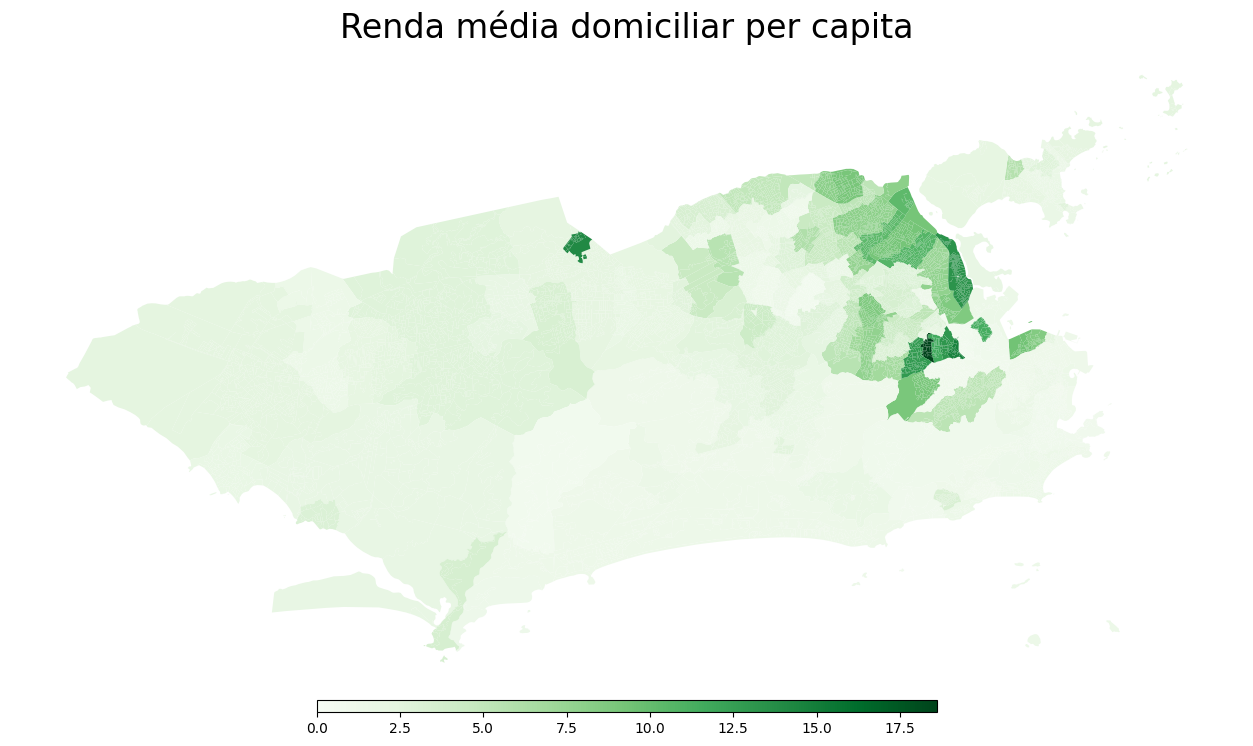

In [10]:
def plot_map(
        gdf, 
        column, 
        title, 
        cmap='viridis', 
        figsize=(16, 10),
        alpha=0.5
    ):
    # Filter the GeoDataFrame to only the column of interest
    gdf = gdf[['geometry', column]]
    
    # Plot the GeoDataFrame
    ax = gdf.plot(
        column=column, 
        figsize=figsize, 
        alpha=alpha, 
        cmap=cmap, 
        # edgecolor='k', 
        legend=True,
        legend_kwds={'orientation': 'horizontal', 'shrink': 0.5, 'pad': 0.01, 'aspect': 50},
        vmin=0    
    )

    ax.set_axis_off()
    
    plt.title(title, fontsize=24)
    plt.show()


plot_map(
    gdf_rio_join, 
    column=v6532, 
    title='Renda média domiciliar per capita',
    cmap='Greens',
    alpha=1,
    figsize=(16, 10)
    )

C:\Users\gianl\AppData\Local\Temp\ipykernel_20216\3881964971.py:14: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='horizontal', fraction=0.046, pad=0.04, ax=ax)


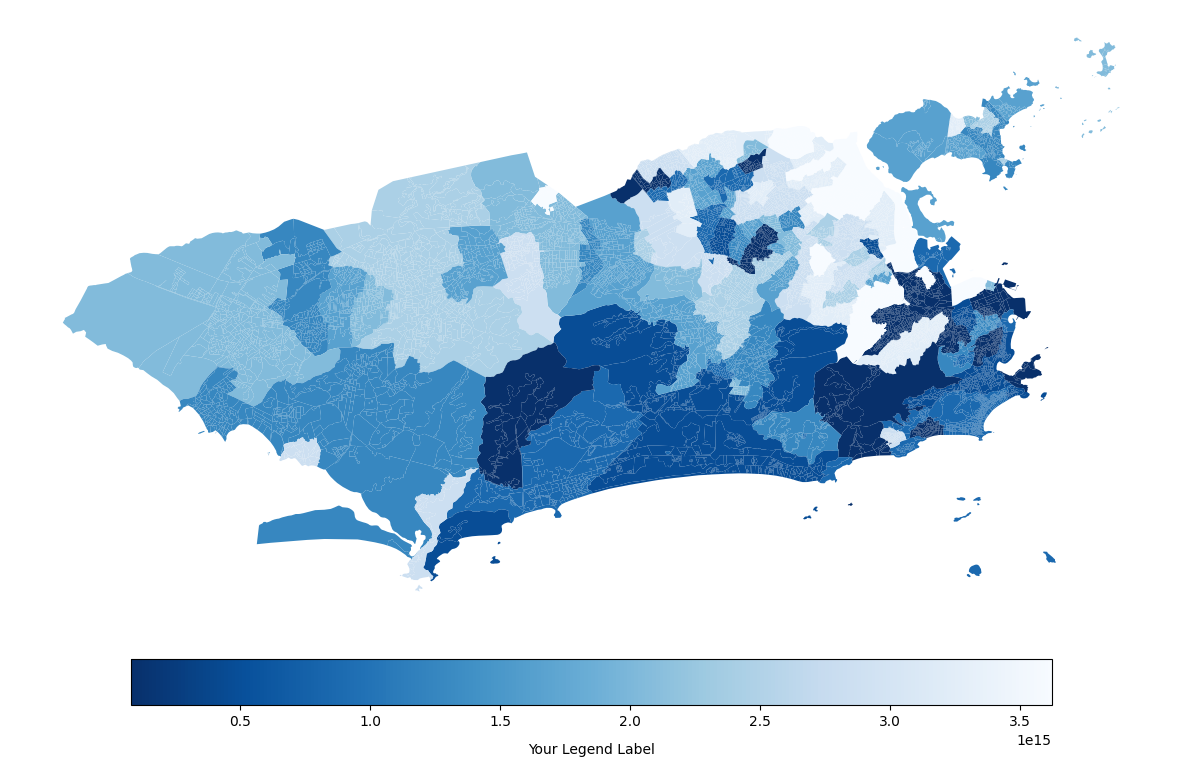

In [18]:
ax = gdf_rio_join.plot(
    column=v6532 + '_ponderado', 
    figsize=(15, 13), 
    scheme='quantiles', 
    k=10, 
    cmap='Blues_r', 
    legend=False,
    # legend_kwds={'orientation': 'horizontal', 'shrink': 0.5, 'pad': 0.01, 'aspect': 50},
    ).set_axis_off();

sm = plt.cm.ScalarMappable(cmap='Blues_r', norm=plt.Normalize(vmin=gdf_rio_join[v6532 + '_ponderado'].min(), vmax=gdf_rio_join[v6532 + '_ponderado'].max()))
sm._A = []

cbar = plt.colorbar(sm, orientation='horizontal', fraction=0.046, pad=0.04, ax=ax)
cbar.set_label('Your Legend Label', labelpad=10)  # Set your legend label

plt.show()